In [28]:
import corner
import matplotlib.pyplot as plt
import numpy as np

import lmfit

In [25]:
from numpy import exp, linspace, random, log

In [9]:
def gaussian(x, amp, cen, wid):
    return amp * exp(-(x-cen)**2 / wid)

In [10]:
from scipy.optimize import curve_fit

x = linspace(-10, 10, 101)
y = gaussian(x, 2.33, 0.21, 1.51) + random.normal(0, 0.2, x.size)

init_vals = [1, 0, 1]  # for [amp, cen, wid]
best_vals, covar = curve_fit(gaussian, x, y, p0=init_vals)
print('best_vals: {}'.format(best_vals))

best_vals: [2.24367428 0.19726065 1.76965723]


In [11]:
from lmfit import Model

gmodel = Model(gaussian)
print('parameter names: {}'.format(gmodel.param_names))
print('independent variables: {}'.format(gmodel.independent_vars))

parameter names: ['amp', 'cen', 'wid']
independent variables: ['x']


In [14]:
params = gmodel.make_params(cen=5, amp=200, wid=1)


In [15]:
params

Parameters([('amp', <Parameter 'amp', 200, bounds=[-inf:inf]>),
            ('cen', <Parameter 'cen', 5, bounds=[-inf:inf]>),
            ('wid', <Parameter 'wid', 1, bounds=[-inf:inf]>)])

In [16]:
x_eval = linspace(0, 10, 201)
y_eval = gmodel.eval(params, x=x_eval)

In [ ]:
# or
# y_eval = gmodel.eval(x=x_eval, cen=6.5, amp=100, wid=2.0)

In [18]:
result = gmodel.fit(y, x=x, cen=6.5, amp=100, wid=2.0)


In [19]:
result

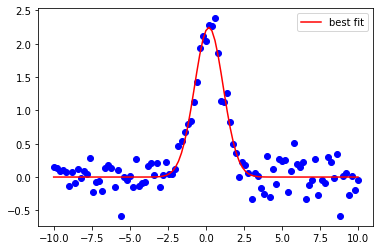

In [21]:
plt.plot(x, y, 'bo')
# plt.plot(x, result.init_fit, 'k--', label='initial fit')
plt.plot(x, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

In [26]:
emcee_kws = dict(steps=1000, burn=300, thin=20, is_weighted=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=log(0.1), min=log(0.001), max=log(2.0))

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 101
    # variables        = 4
    chi-square         = 97.1359074
    reduced chi-square = 1.00140111
    Akaike info crit   = 4.06004939
    Bayesian info crit = 14.5205315
[[Variables]]
    amp:        2.23725558 +/- 0.08506389 (3.80%) (init = 2.243681)
    cen:        0.19656359 +/- 0.03990043 (20.30%) (init = 0.1972641)
    wid:        1.78606955 +/- 0.16208653 (9.08%) (init = 1.769636)
    __lnsigma: -1.61994073 +/- 0.07113663 (4.39%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.602


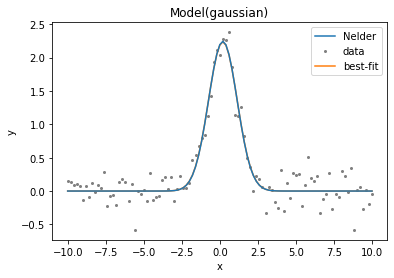

In [29]:
result_emcee = gmodel.fit(data=y, x=x, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

lmfit.report_fit(result_emcee)

ax = plt.plot(x, gmodel.eval(params=result.params, x=x), label='Nelder', zorder=100)
result_emcee.plot_fit(ax=ax, data_kws=dict(color='gray', markersize=2))
plt.show()

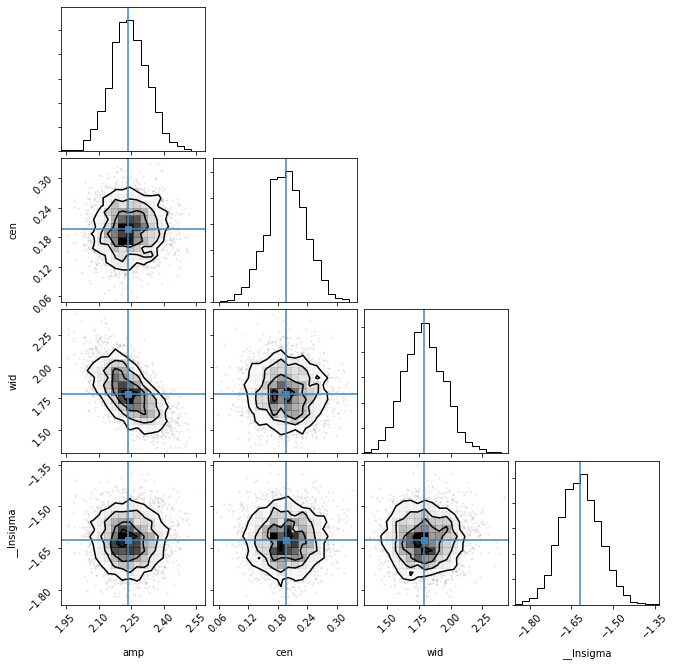

In [30]:
emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names,
                             truths=list(result_emcee.params.valuesdict().values()))

In [32]:
print("\nmedian of posterior probability distribution")
print('--------------------------------------------')
lmfit.report_fit(result_emcee.params)

# find the maximum likelihood solution
highest_prob = np.argmax(result_emcee.lnprob)
hp_loc = np.unravel_index(highest_prob, result_emcee.lnprob.shape)
mle_soln = result_emcee.chain[hp_loc]
print("\nMaximum likelihood Estimation")
print('-----------------------------')
for ix, param in enumerate(emcee_params):
    print(param + ': ' + str(mle_soln[ix]))

quantiles = np.percentile(result_emcee.flatchain['amp'], [2.28, 15.9, 50, 84.2, 97.7])
print("\n\n1 sigma spread", 0.5 * (quantiles[3] - quantiles[1]))
print("2 sigma spread", 0.5 * (quantiles[4] - quantiles[0]))


median of posterior probability distribution
--------------------------------------------
[[Variables]]
    amp:        2.23725558 +/- 0.08506389 (3.80%) (init = 2.243681)
    cen:        0.19656359 +/- 0.03990043 (20.30%) (init = 0.1972641)
    wid:        1.78606955 +/- 0.16208653 (9.08%) (init = 1.769636)
    __lnsigma: -1.61994073 +/- 0.07113663 (4.39%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.602

Maximum likelihood Estimation
-----------------------------
amp: 2.253405415185262
cen: 0.19834021446491024
wid: 1.7705711843694905
__lnsigma: -1.6408673777335743


1 sigma spread 0.08507958235116497
2 sigma spread 0.1746121397625673
